# Smart Urban System - NLP Module Development


## Phase 1: Sources Loading and data extraction and exploration


In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Add src to path
src_path = Path("../src").resolve()
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from preprocessor import SmartUrbanPreprocessor
from config import DATA_PATHS

print("Environment checked. Loading Preprocessor...")

Environment checked. Loading Preprocessor...


## Phase 2: Corpus Acquisition & Preprocessing

This notebook handles the loading, normalization, and cleaning of the heterogeneous corpus.


### 1. Load Raw Data


In [2]:
processor = SmartUrbanPreprocessor()
raw_data = processor.load_data()

for source, df in raw_data.items():
    print(f"{source}: {len(df)} rows")

Initializing NLP models...
Loading Stores Complaints...
Loading Financial Complaints...
Loading University Complaints...
Loading Amazon Reviews...
Loading News Sentiments...
Falling back to ISO-8859-1 encoding for news
Removing non-UTF-8 characters from news text
Removing non-UTF-8 characters from news sentiment
Converted news to UTF-8
stores: 81883 rows
financial: 162421 rows
university: 1005 rows
amazon: 30000 rows
news: 4846 rows


In [3]:
{k: v.shape for k, v in raw_data.items()}

{'stores': (81883, 24),
 'financial': (162421, 3),
 'university': (1005, 8),
 'amazon': (30000, 9),
 'news': (4846, 2)}

In [4]:
stores = raw_data["stores"]
financial = raw_data["financial"]
university = raw_data["university"]
reviews = raw_data["amazon"]
news = raw_data["news"]

dfs = {
    "stores": stores,
    "financial": financial,
    "university": university,
    "reviews": reviews,
    "news": news,
}

#### 1.1 Preliminar EDA


In [5]:
{k: df.head(2) for k, df in dfs.items()}

{'stores':       ID_EXP FECHA_INGRESO            FECHA_FIN      FECHA DE CIERRE  \
 0  2022_3584    2022-01-03  2022-08-15 00:00:00  2022-08-15 00:00:00   
 1  2022_2645    2022-01-03  2022-03-29 00:00:00  2022-03-29 00:00:00   
 
                TIPO_CONCILIACION ESTADO_PROCESAL  \
 0  Turnada a Concil Person p/seg      Conciliada   
 1  Turnada a Concil Person p/seg   Desistimiento   
 
                             PROVEEDOR                    NOMBRE_COMERCIAL  \
 0  DIVERSIDAD PARA EL HOGAR, SA DE CV  DIVERSIDAD PARA EL HOGAR, SA DE CV   
 1                        PROMEDIO 100                        PROMEDIO 100   
 
                                     GIRO  \
 0                              MUEBLERÍA   
 1  ESCUELA DE EDUCACIÓN PRIMARIA PRIVADA   
 
                                   SECTOR  ... COSTO BIEN SERVICIO  \
 0                               MUEBLERO  ...               16878   
 1  ESCUELA DE EDUCACIÓN PRIMARIA PRIVADA  ...             51111.8   
 
   MONTO RECLAMADO MONT

In [6]:
{k: (df.shape, df.dtypes) for k, df in raw_data.items()}

{'stores': ((81883, 24),
  ID_EXP                         object
  FECHA_INGRESO          datetime64[ns]
  FECHA_FIN                      object
  FECHA DE CIERRE                object
  TIPO_CONCILIACION              object
  ESTADO_PROCESAL                object
  PROVEEDOR                      object
  NOMBRE_COMERCIAL               object
  GIRO                           object
  SECTOR                         object
  ODECO                          object
  ESTADO_UA                      object
  TIPO_RECLAMACION               object
  MOTIVO_RECLAMACION             object
  COSTO BIEN SERVICIO            object
  MONTO RECLAMADO               float64
  MONTO RECUPERADO               object
  PROCEDIMIENTO                  object
  BIEN O SERV                    object
  MEDIO INGRESO                  object
  TIPO PROD                      object
  MODALIDAD COMPRA               object
  MODALIDAD PAGO                 object
  PROB ESPECIAL                  object
  dtype: object

In [7]:
# Detailed EDA for each dataset
for name, df in dfs.items():
    print(f"\nMissing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({
        'Count': missing,
        'Percentage': missing_pct
    })
    display(missing_df[missing_df['Count'] > 0])
    
    # Basic statistics for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nNumeric Statistics:")
        display(df[numeric_cols].describe())
    
    # Unique values for categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"\nCategorical Columns - Unique Value Counts:")
        for col in categorical_cols[:5]:  # Show first 5 categorical columns
            unique_count = df[col].nunique()
            print(f"  {col}: {unique_count} unique values")
            if unique_count <= 10:
                print(f"    Values: {df[col].unique()}")
    
    # Sample of data
    print(f"\nSample Data (first 3 rows):")
    display(df.head(3))

# Summary comparison across datasets
print(f"\n\n{'='*60}")
print("DATASET COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_data = []
for name, df in dfs.items():
    comparison_data.append({
        'Dataset': name,
        'Rows': df.shape[0],
        'Columns': df.shape[1],
        'Numeric Columns': len(df.select_dtypes(include=[np.number]).columns),
        'Categorical Columns': len(df.select_dtypes(include=['object']).columns),
        'Missing Values': df.isnull().sum().sum(),
        'Missing %': round(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100, 2)
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)



Missing Values:


,Count,Percentage
TIPO_RECLAMACION,21254,25.96
MOTIVO_RECLAMACION,21254,25.96
COSTO BIEN SERVICIO,212,0.26
MONTO RECLAMADO,50706,61.92
MONTO RECUPERADO,50702,61.92
MODALIDAD PAGO,282,0.34



Numeric Statistics:


,MONTO RECLAMADO
count,3.117700e+04
mean,1.644598e+04
std,1.112201e+05
min,0.000000e+00
25%,0.000000e+00
50%,2.290000e+02
75%,7.976000e+03
max,8.247000e+06



Categorical Columns - Unique Value Counts:
  ID_EXP: 76001 unique values
  FECHA_FIN: 292 unique values
  FECHA DE CIERRE: 293 unique values
  TIPO_CONCILIACION: 7 unique values
    Values: ['Turnada a Concil Person p/seg' 'Turnada a Concil Medios Elec.'
 'Turnada a Concil Resi p/ segui' 'Turnada a Concil Telefónica'
 'Turnada a Concil Domiciliaria' 'En Proceso' 'Cancelada']
  ESTADO_PROCESAL: 6 unique values
    Values: ['Conciliada' 'Desistimiento' 'En Trámite' 'No Conciliada' 'Improcedente'
 'Cancelada']

Sample Data (first 3 rows):


,ID_EXP,FECHA_INGRESO,FECHA_FIN,FECHA DE CIERRE,TIPO_CONCILIACION,ESTADO_PROCESAL,PROVEEDOR,NOMBRE_COMERCIAL,GIRO,SECTOR,...,COSTO BIEN SERVICIO,MONTO RECLAMADO,MONTO RECUPERADO,PROCEDIMIENTO,BIEN O SERV,MEDIO INGRESO,TIPO PROD,MODALIDAD COMPRA,MODALIDAD PAGO,PROB ESPECIAL
0,2022_3584,2022-01-03,2022-08-15 00:00:00,2022-08-15 00:00:00,Turnada a Concil Person p/seg,Conciliada,"DIVERSIDAD PARA EL HOGAR, SA DE CV","DIVERSIDAD PARA EL HOGAR, SA DE CV",MUEBLERÍA,MUEBLERO,...,16878,16878.0,22688,Conciliación personal,Bien,Escrito,Producto nuevo,En establecimiento físico,Contado,No problema especial
1,2022_2645,2022-01-03,2022-03-29 00:00:00,2022-03-29 00:00:00,Turnada a Concil Person p/seg,Desistimiento,PROMEDIO 100,PROMEDIO 100,ESCUELA DE EDUCACIÓN PRIMARIA PRIVADA,ESCUELA DE EDUCACIÓN PRIMARIA PRIVADA,...,51111.8,NaN,NaN,Conciliación personal,Servicio,Personal,Servicio normal,En establecimiento físico,Plazos,No problema especial
2,2022_2916,2022-01-03,-,-,Turnada a Concil Person p/seg,En Trámite,MARCELO JIMENEZ MENDEZ,MARCELO JIMENEZ MENDEZ,"COLOCADOR DE VIDRIERÍA, CANCELES Y ALUMINIOS","COLOCADOR DE VIDRIERÍA, CANCELES Y ALUMINIOS",...,103300,NaN,NaN,Sol. de Dictamen,Servicio,Personal,Servicio normal,En establecimiento físico,Contado,No problema especial



Missing Values:


,Count,Percentage
narrative,10,0.01



Numeric Statistics:


,Unnamed: 0
count,162421.000000
mean,81210.000000
std,46887.048373
min,0.000000
25%,40605.000000
50%,81210.000000
75%,121815.000000
max,162420.000000



Categorical Columns - Unique Value Counts:
  product: 5 unique values
    Values: ['credit_card' 'retail_banking' 'credit_reporting' 'mortgages_and_loans'
 'debt_collection']
  narrative: 124472 unique values

Sample Data (first 3 rows):


,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...



Missing Values:


,Count,Percentage



Numeric Statistics:


,Age,Gpa,Year,Count
count,1005.000000,1005.000000,1005.000000,1005.0
mean,21.298507,2.088856,2.684577,1.0
std,3.338841,1.208738,1.461665,0.0
min,16.000000,0.010000,1.000000,1.0
25%,18.000000,1.080000,1.000000,1.0
50%,21.000000,2.110000,2.000000,1.0
75%,24.000000,3.090000,4.000000,1.0
max,27.000000,4.970000,5.000000,1.0



Categorical Columns - Unique Value Counts:
  Genre: 11 unique values
  Reports: 1001 unique values
  Gender: 2 unique values
    Values: ['M' 'F']
  Nationality: 7 unique values
    Values: ['Egypt' 'Soudan' 'France' 'Mexico' 'South Africa' 'Yemen' 'Indonesia']

Sample Data (first 3 rows):


,Genre,Reports,Age,Gpa,Year,Count,Gender,Nationality
0,Academic Support and Resources,The limited access to research databases and m...,27,2.18,2,1,M,Egypt
1,Academic Support and Resources,I'm having trouble finding the course material...,23,3.11,2,1,F,Egypt
2,Academic Support and Resources,It's frustrating to have limited access to res...,20,3.68,2,1,F,Egypt



Missing Values:


,Count,Percentage
review_title,1,0.0



Numeric Statistics:


,Unnamed: 0,stars
count,30000.000000,30000.000000
mean,14999.500000,3.000000
std,8660.398374,1.414237
min,0.000000,1.000000
25%,7499.750000,2.000000
50%,14999.500000,3.000000
75%,22499.250000,4.000000
max,29999.000000,5.000000



Categorical Columns - Unique Value Counts:
  review_id: 30000 unique values
  product_id: 29798 unique values
  reviewer_id: 29923 unique values
  review_body: 29981 unique values
  review_title: 24932 unique values

Sample Data (first 3 rows):


,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,de_0784695,product_de_0572654,reviewer_de_0645436,1,"Leider, leider nach einmal waschen ausgebliche...",Leider nicht zu empfehlen,de,home
1,1,de_0759207,product_de_0567331,reviewer_de_0183703,1,zunächst macht der Anker Halter einen soliden ...,Gummierung nach 6 Monaten kaputt,de,wireless
2,2,de_0711785,product_de_0482105,reviewer_de_0182152,1,Siegel sowie Verpackung war beschädigt und war...,Flohmarkt ware,de,industrial_supplies



Missing Values:


,Count,Percentage



Categorical Columns - Unique Value Counts:
  sentiment: 3 unique values
    Values: ['neutral' 'negative' 'positive']
  text: 4838 unique values

Sample Data (first 3 rows):


,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...




DATASET COMPARISON SUMMARY


,Dataset,Rows,Columns,Numeric Columns,Categorical Columns,Missing Values,Missing %
0,stores,81883,24,1,22,144410,7.35
1,financial,162421,3,1,2,10,0.00
2,university,1005,8,4,4,0,0.00
3,reviews,30000,9,2,7,1,0.00
4,news,4846,2,0,2,0,0.00


### 2. Unify Schema


In [8]:
unified_df = processor.normalize(raw_data)
print(unified_df.shape)
display(unified_df.head(5))
print(unified_df.dtypes)

(280155, 5)


,id,text,source,language,sentiment_score
0,de_0784695,"Leider, leider nach einmal waschen ausgebliche...",amazon,de,bad
1,de_0759207,zunächst macht der Anker Halter einen soliden ...,amazon,de,bad
2,de_0711785,Siegel sowie Verpackung war beschädigt und war...,amazon,de,bad
3,de_0964430,Habe dieses Produkt NIE erhalten und das Geld ...,amazon,de,bad
4,de_0474538,Die Träger sind schnell abgerissen Reißverschl...,amazon,de,bad


id                 object
text               object
source             object
language           object
sentiment_score    object
dtype: object


In [9]:
# Missing values
missing = unified_df.isnull().sum()
missing_pct = (missing / len(unified_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Count': missing,
})
display(missing_df)
print(unified_df.shape)
working_df = unified_df[unified_df['text'].notna()]
print(working_df.shape)

print("")

# Unique values
categorical_cols = working_df.select_dtypes(include=['object']).columns
for col in categorical_cols:  
    unique_count = working_df[col].nunique()
    print(f"- Column {col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"\t- Values: {working_df[col].unique()}")


,Count
id,0
text,1
source,0
language,0
sentiment_score,0


(280155, 5)
(280154, 5)

- Column id: 192420 unique values
- Column text: 273270 unique values
- Column source: 5 unique values
	- Values: ['amazon' 'stores' 'financial' 'university' 'news']
- Column language: 6 unique values
	- Values: ['de' 'en' 'es' 'fr' 'ja' 'zh']
- Column sentiment_score: 3 unique values
	- Values: ['bad' 'neutral' 'good']


### 3. Cleaning & Preprocessing


In [ ]:
clean_df = processor.process_corpus(unified_df, apply_spell_correction=False)
# spell_correction_clean_df = processor.process_corpus(unified_df, apply_spell_correction=True)
display(clean_df.head())
# display(spell_correction_clean_df.head())

Processing corpus with 280155 documents...
Removing duplicates...
Removed 6884 duplicate entries
Cleaning text...


C:\Users\otero\Documents\PKM\200 - BEREICHE - AREAS\UNIVERSITÄT - Universidad\UTAMED\PLN\raa\src\preprocessor.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(self.clean_text)


Tokenizing and lemmatizing...


Processing: 100%|██████████| 273271/273271 [13:43<00:00, 331.77it/s]  
C:\Users\otero\Documents\PKM\200 - BEREICHE - AREAS\UNIVERSITÄT - Universidad\UTAMED\PLN\raa\src\preprocessor.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = [r['tokens'] for r in results]
C:\Users\otero\Documents\PKM\200 - BEREICHE - AREAS\UNIVERSITÄT - Universidad\UTAMED\PLN\raa\src\preprocessor.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmas'] = [r['lemmas'] for r in results]
C:\Users\otero\Docume

Processing complete. Final corpus size: 273271 documents
Processing corpus with 280155 documents...
Removing duplicates...
Removed 6884 duplicate entries
Cleaning text...


C:\Users\otero\Documents\PKM\200 - BEREICHE - AREAS\UNIVERSITÄT - Universidad\UTAMED\PLN\raa\src\preprocessor.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(self.clean_text)


Applying spell correction...


KeyboardInterrupt: 

### 4. Analysis & Distribution


C:\Users\otero\AppData\Local\Temp\ipykernel_19244\867056193.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['text_length'] = clean_df['text'].str.len()
C:\Users\otero\AppData\Local\Temp\ipykernel_19244\867056193.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['text_length'] = clean_df['text'].str.len()


ModuleNotFoundError: No module named 'wordcloud'

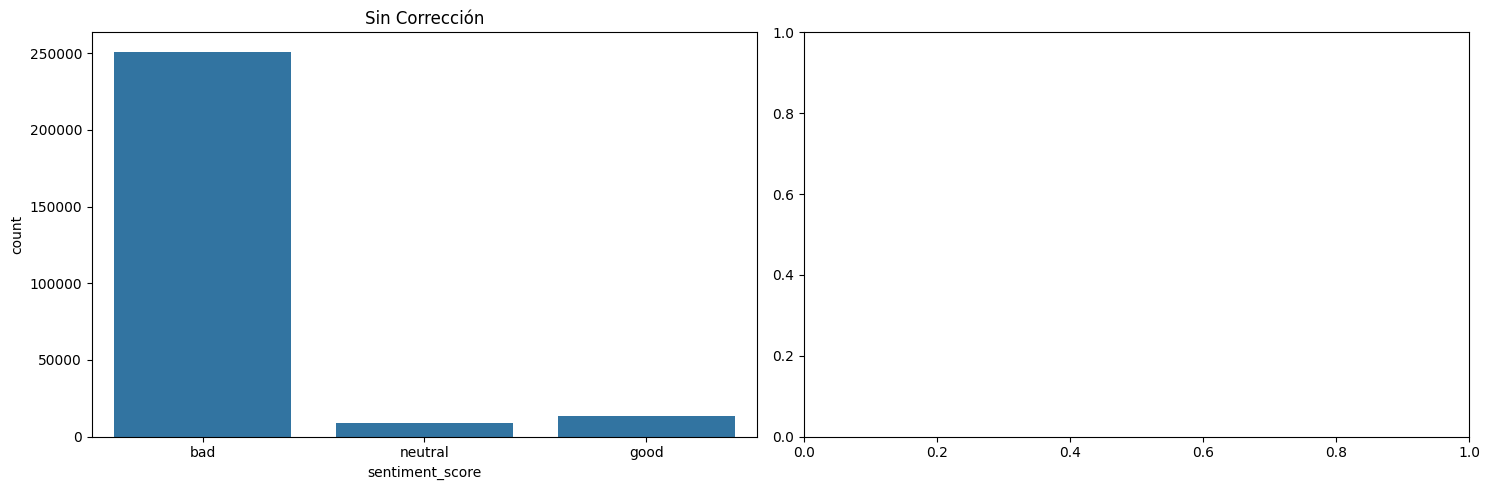

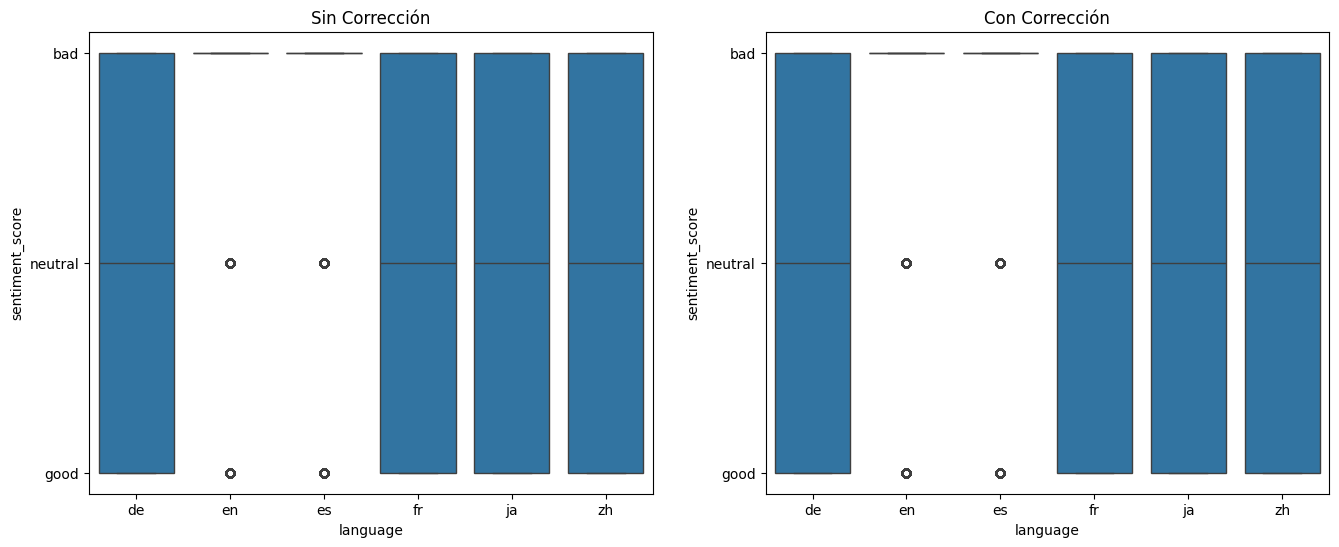

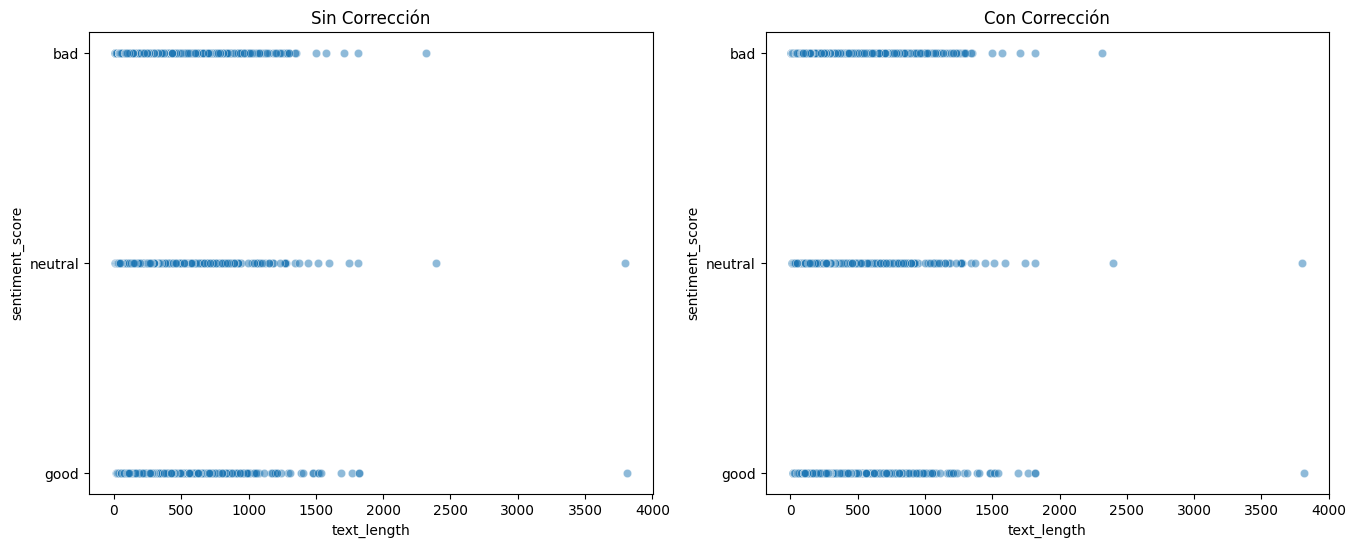

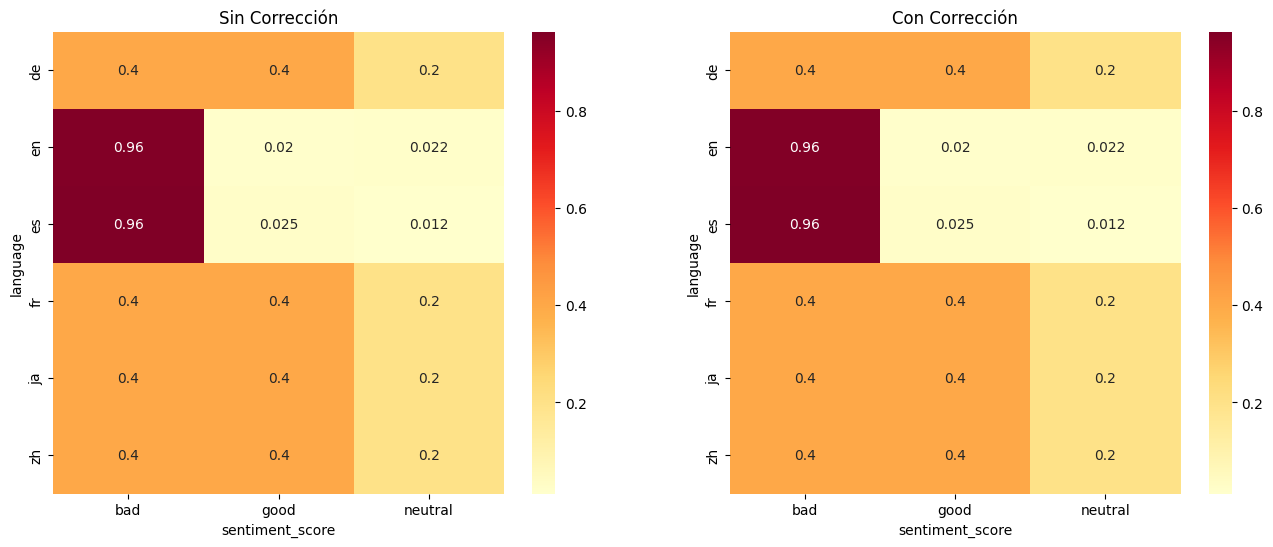

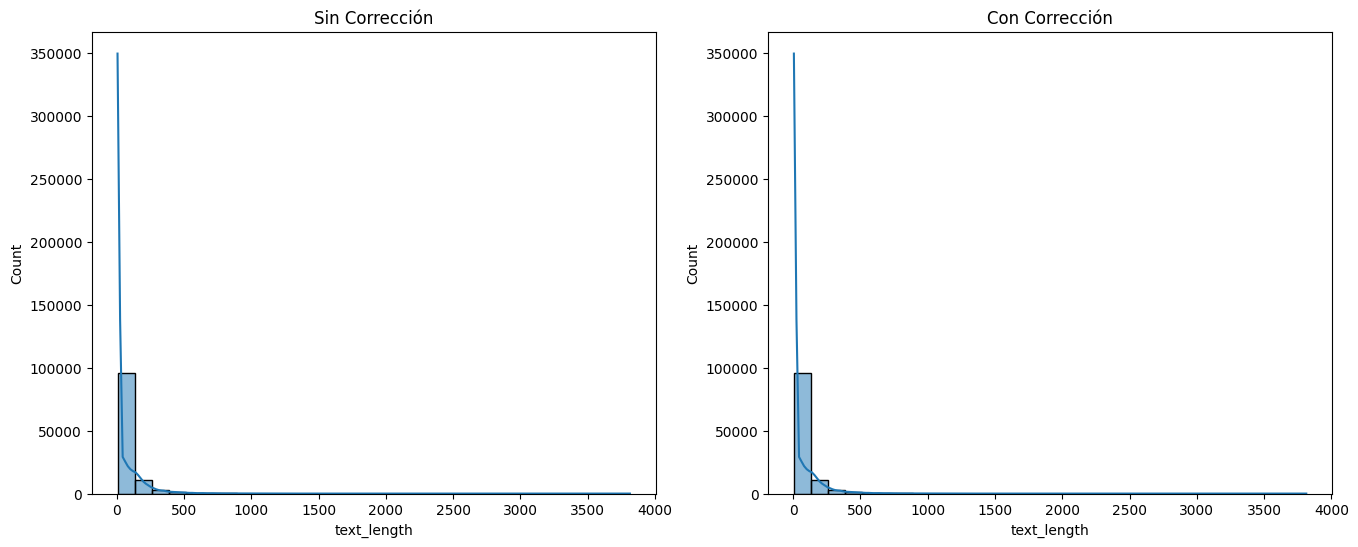

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=clean_df, x='sentiment_score', ax=axes[0])
axes[0].set_title("Sin Corrección")
sns.countplot(data=spell_correction_clean_df, x='sentiment_score', ax=axes[1])
axes[1].set_title("Con Corrección")
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=clean_df, x='language', y='sentiment_score', ax=axes[0])
axes[0].set_title("Sin Corrección")
sns.boxplot(data=spell_correction_clean_df, x='language', y='sentiment_score', ax=axes[1])
axes[1].set_title("Con Corrección")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
clean_df['text_length'] = clean_df['text'].str.len()
spell_correction_clean_df['text_length'] = spell_correction_clean_df['text'].str.len()

sns.scatterplot(data=clean_df, x='text_length', y='sentiment_score', alpha=0.5, ax=axes[0])
axes[0].set_title("Sin Corrección")
sns.scatterplot(data=spell_correction_clean_df, x='text_length', y='sentiment_score', alpha=0.5, ax=axes[1])
axes[1].set_title("Con Corrección")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sin corrección
pivot1 = pd.crosstab(clean_df['language'], clean_df['sentiment_score'], normalize='index')
sns.heatmap(pivot1, annot=True, cmap='YlOrRd', ax=axes[0])
axes[0].set_title("Sin Corrección")

# Con corrección
pivot2 = pd.crosstab(spell_correction_clean_df['language'], spell_correction_clean_df['sentiment_score'], normalize='index')
sns.heatmap(pivot2, annot=True, cmap='YlOrRd', ax=axes[1])
axes[1].set_title("Con Corrección")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data=clean_df, x='text_length', bins=30, kde=True, ax=axes[0])
axes[0].set_title("Sin Corrección")
sns.histplot(data=spell_correction_clean_df, x='text_length', bins=30, kde=True, ax=axes[1])
axes[1].set_title("Con Corrección")


from wordcloud import WordCloud

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sentiments = clean_df['sentiment_score'].unique()

for idx, sentiment in enumerate(sentiments):
    text = ' '.join(clean_df[clean_df['sentiment_score'] == sentiment]['text'].fillna(''))
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)
    axes[idx//2, idx%2].imshow(wordcloud)
    axes[idx//2, idx%2].set_title(f"Sentiment: {sentiment}")
    axes[idx//2, idx%2].axis('off')


from collections import Counter

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sentiments = clean_df['sentiment_score'].unique()

for idx, sentiment in enumerate(sentiments):
    texts = clean_df[clean_df['sentiment_score'] == sentiment]['text'].fillna('')
    words = ' '.join(texts).split()
    word_counts = Counter(words).most_common(10)
    
    words_list, counts = zip(*word_counts)
    axes[idx//2, idx%2].barh(words_list, counts)
    axes[idx//2, idx%2].set_title(f"Top 10 - Sentiment: {sentiment}")
    axes[idx//2, idx%2].invert_yaxis()


plt.figure(figsize=(12, 6))
sns.violinplot(data=clean_df, x='language', y='sentiment_score', inner='box')
plt.title("Distribución de Sentimiento por Idioma")
plt.xticks(rotation=45)


# Si tienes más columnas numéricas
numeric_cols = ['text_length', 'sentiment_score']
sns.pairplot(clean_df[numeric_cols + ['language']], hue='language')


plt.figure(figsize=(10, 8))
clean_df['language'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Distribución de Idiomas")
plt.ylabel('')


plt.figure(figsize=(12, 6))
for lang in clean_df['language'].unique():
    data = clean_df[clean_df['language'] == lang]['sentiment_score']
    sns.kdeplot(data, label=lang, fill=True, alpha=0.3)
plt.title("Densidad de Sentimiento por Idioma")
plt.legend()


from math import pi

categories = ['Mean Sentiment', 'Std Sentiment', 'Mean Length', 'Std Length']
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

# Calcular métricas
metrics_clean = [
    clean_df['sentiment_score'].mean(),
    clean_df['sentiment_score'].std(),
    clean_df['text_length'].mean(),
    clean_df['text_length'].std()
]

metrics_spell = [
    spell_correction_clean_df['sentiment_score'].mean(),
    spell_correction_clean_df['sentiment_score'].std(),
    spell_correction_clean_df['text_length'].mean(),
    spell_correction_clean_df['text_length'].std()
]

# Normalizar
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

metrics_clean += metrics_clean[:1]
metrics_spell += metrics_spell[:1]

ax.plot(angles, metrics_clean, 'o-', linewidth=2, label='Sin Corrección')
ax.plot(angles, metrics_spell, 'o-', linewidth=2, label='Con Corrección')
ax.fill(angles, metrics_clean, alpha=0.25)
ax.fill(angles, metrics_spell, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.legend()
plt.title("Comparación de Métricas")


import squarify

plt.figure(figsize=(12, 8))
sizes = clean_df['language'].value_counts().values
labels = clean_df['language'].value_counts().index
squarify.plot(sizes=sizes, label=labels, alpha=0.8)
plt.title("Treemap de Idiomas")
plt.axis('off')


plt.figure(figsize=(10, 8))
numeric_df = clean_df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")


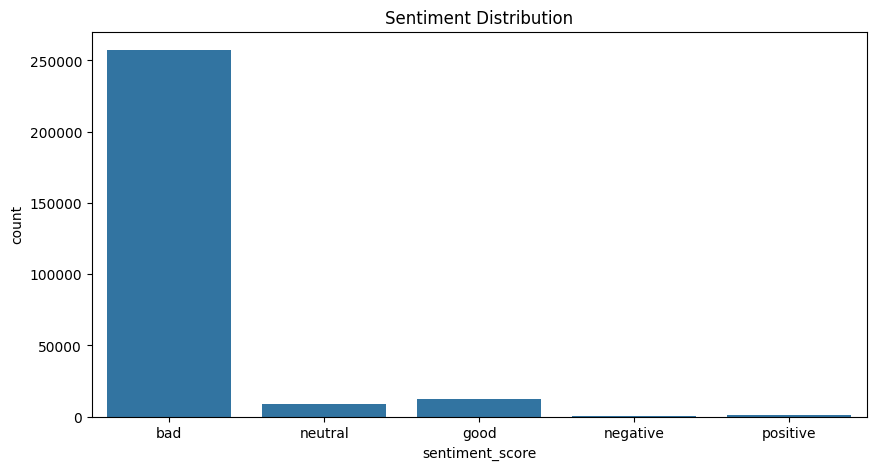

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=clean_df, x='sentiment_score')
plt.title("Sentiment Distribution")
plt.show()

In [11]:
# Save processed data
output_path = Path("../data/processed_corpus.csv")
clean_df.to_csv(output_path, index=False)
# spell_correction_clean_df.to_csv(Path("../data/processed_corpus_spell_corrected.csv"), index=False)
print(f"Saved to {output_path}")

Saved to ..\data\processed_corpus.csv
